Task: Do a hello world continual learning model with omniglot data set using the  avalanche continual learning framework 

- Reference: https://avalanche.continualai.org/from-zero-to-hero-tutorial/02_models 

In [ ]:
#!pip install git+https://github.com/ContinualAI/avalanche.git

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import torchvision

from avalanche.models import SimpleMLP
from avalanche.training.strategies import Naive
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, \
    loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin

from torch.utils.data import DataLoader
from avalanche.benchmarks.datasets import Omniglot
from torchvision import datasets, transforms

## Load Dataset
The Omniglot dataset contains 1623 (964 when load from pytorch) different handwritten characters from 50 different alphabets

In [96]:
img_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_omni = Omniglot('./data/omniglot', train=True, download=True, transform = img_transform)
test_omni = Omniglot('./data/omniglot', train=False, download=True, transform = img_transform)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
# create a new benchmark
scenario = ni_benchmark(
    train_omni, test_omni, n_experiences=5, shuffle=True, seed=1234,
    balance_experiences=True
)

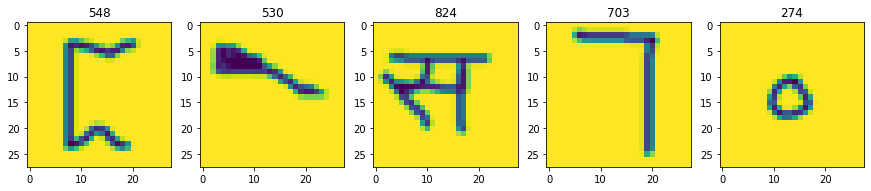

In [98]:
fig, axis = plt.subplots(1, 5, figsize=(15, 15))

for i, ax in enumerate(axis.flat):
    image = train_omni[random.randint(0, len(train_omni))]
    ax.imshow(np.squeeze(np.squeeze(image[0])))
    ax.set_title(image[1])

## Avalanche Continual Learning


## Model Config

In [105]:
# Config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model
model = SimpleMLP(num_classes=scenario.n_classes) # 964 classes 

In [106]:
from avalanche.models import as_multitask
mt_model = as_multitask(model, 'classifier')
print(mt_model)

MultiTaskDecorator(
  (model): SimpleMLP(
    (features): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
    )
    (classifier): Sequential()
  )
  (classifier): MultiHeadClassifier(
    (classifiers): ModuleDict(
      (0): IncrementalClassifier(
        (classifier): Linear(in_features=512, out_features=964, bias=True)
      )
    )
  )
)


In [107]:
# log to Tensorboard
tb_logger = TensorboardLogger()
# log to text file
text_logger = TextLogger(open('log.txt', 'a'))
# print to stdout
interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    cpu_usage_metrics(experience=True),
    confusion_matrix_metrics(num_classes=scenario.n_classes, save_image=False,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger]
)

/usr/local/lib/python3.7/dist-packages/avalanche/training/plugins/evaluation.py:84: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  "No benchmark provided to the evaluation plugin. "


In [108]:
cl_strategy = Naive(
    mt_model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=500, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

In [109]:
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", len(experience.classes_in_this_experience))
    print('Task {} batch {} -> train'.format(experience.task_label, experience.current_experience))
    print('This batch contains', len(experience.dataset), 'patterns')   

    # train returns a dictionary which contains all the metric values  
    res = cl_strategy.train(experience)
    print('Training completed')
    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  964
Task 0 batch 0 -> train
This batch contains 3856 patterns
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --
100%|██████████| 8/8 [00:13<00:00,  1.65s/it]
Epoch 0 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 158202.2490
	DiskUsage_MB/train_phase/train_stream/Task000 = 158202.2490
	Loss_Epoch/train_phase/train_stream/Task000 = 6.9275
	Loss_MB/train_phase/train_stream/Task000 = 6.9321
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0445
	Time_Epoch/train_phase/train_stream/Task000 = 11.9054
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0018
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0000
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 132/132 [03:01<00:00,  1.38s/it]
> Eval on ex